In [1]:
# for saving model
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

sns.color_palette("tab10")

import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
data = pd.read_csv(r"Traffic.csv")
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


Data is good:
- No null
- No duplicate

In [3]:
data2 = data.drop(['Time', 'Date', 'Day of the week'], axis=1)
y = data2['Traffic Situation']

data2.describe()

,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,68.696573,14.917339,15.279570,15.324933,114.218414
std,45.850693,12.847518,14.341986,10.603833,60.190627
min,6.000000,0.000000,0.000000,0.000000,21.000000
25%,19.000000,5.000000,1.000000,6.000000,55.000000
50%,64.000000,12.000000,12.000000,14.000000,109.000000
75%,107.000000,22.000000,25.000000,23.000000,164.000000
max,180.000000,70.000000,50.000000,40.000000,279.000000


## Label Encoder

In [4]:
le = LabelEncoder()
for col in data2.select_dtypes('object').columns:
    data2[col] = le.fit_transform(data2[col])
    
key = data["Traffic Situation"].unique()
value = le.fit_transform(key)

{k: v for(k,v) in zip(key, value)}

{'low': np.int64(2),
 'normal': np.int64(3),
 'heavy': np.int64(0),
 'high': np.int64(1)}

## Scaling data for real time

In [5]:
scale_factor = data[data["Traffic Situation"] == "heavy"]["CarCount"].mean()/10
scale_factor

np.float64(13.088709677419354)

In [6]:
data3  = data2[data2.columns[:-2]] // scale_factor
data3["Total"] = data3[data3.columns[:-2]].sum(axis=1)
data3["Traffic Situation"] = data2["Traffic Situation"]

x = data3[data3.columns[:-1]]
y = data3["Traffic Situation"]

data3.head()

,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,2.0,0.0,0.0,0.0,2.0,2
1,3.0,0.0,0.0,0.0,3.0,2
2,3.0,0.0,0.0,0.0,3.0,2
3,3.0,0.0,0.0,0.0,3.0,2
4,4.0,0.0,1.0,1.0,4.0,3


<Axes: ylabel='Count'>

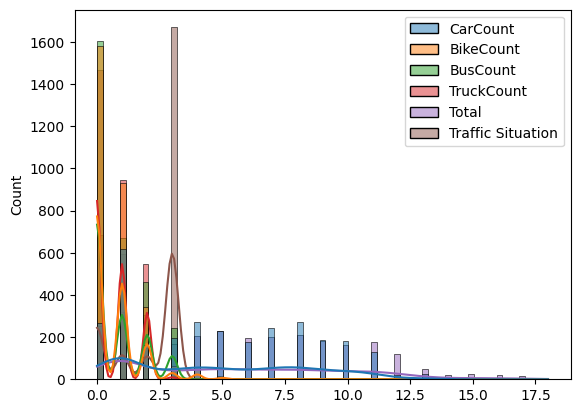

In [7]:
sns.histplot(data=data3, kde=True)

## Models 

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.2)

In [9]:
models = {
    'Linear_Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    # 'XGB': XGBRegressor(),
    'SVM': SVC()
}

results = {'Model': [], 'Accuracy': [],
           'Precision': [], 'Recall': [], 'F1-Score': []}

In [10]:
for label, model in models.items():
    obj = model
    obj.fit(x_train, y_train)
    obj_pred = obj.predict(x_test)

    accuracy = accuracy_score(y_test, obj_pred > 0.5)
    # This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall
    precision = precision_score(y_test, obj_pred > 0.5, average='weighted') 
    recall = recall_score(y_test, obj_pred > 0.5, average='weighted')
    f1 = f1_score(y_test, obj_pred > 0.5, average='weighted')

    results['Model'].append(label)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)


results_df = pd.DataFrame(results)
print(results_df)

               Model  Accuracy  Precision    Recall  F1-Score
0  Linear_Regression  0.209732   0.218946  0.209732  0.160724
1                KNN  0.290268   0.215742  0.290268  0.218660
2       DecisionTree  0.293624   0.209314  0.293624  0.219904
3       RandomForest  0.293624   0.209314  0.293624  0.219904
4                SVM  0.296980   0.197142  0.296980  0.217439


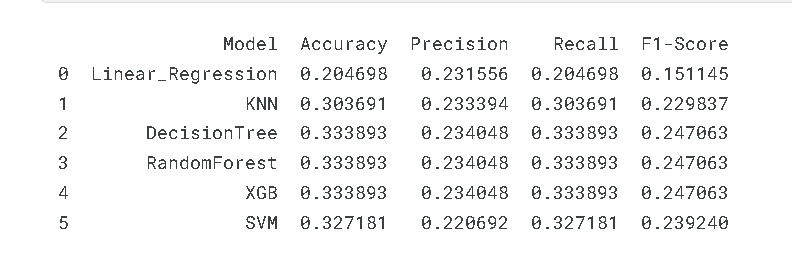

## GridCV, Random Forest

- Note: look at the binary file instead

In [11]:
# svm_model = SVC()
# params = {
#     'kernel': ['poly', 'rbf', 'linear'],
#     'C': [0.1, 10, 100]
# }
# grid = GridSearchCV(svm_model, params, cv=5)
# grid.fit(x_train, y_train)

In [12]:
# with open("traffic_prediction_dapassignment","wb") as file:
#     pickle.dump(grid, file)

In [13]:
# with open("traffic_prediction_dapassignment", "rb") as file:
#     grid:GridSearchCV = pickle.load(file)
    
# grid.best_params_

# print('grid best params=', grid.best_params_)
# print('grid best score =', grid.best_score_)

# y_pred = grid.predict(x_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

In [14]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9110738255033557
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       127
           1       0.84      0.67      0.74        63
           2       0.82      0.95      0.88        66
           3       0.94      0.92      0.93       340

    accuracy                           0.91       596
   macro avg       0.88      0.88      0.88       596
weighted avg       0.91      0.91      0.91       596



## Save the model into file

In [15]:
with open("traffic_prediction_dapassignment","wb") as file:
    pickle.dump(clf, file)

In [16]:
with open("traffic_prediction_dapassignment", "rb") as file:
    m = pickle.load(file)
    
y_pred = m.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9110738255033557
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       127
           1       0.84      0.67      0.74        63
           2       0.82      0.95      0.88        66
           3       0.94      0.92      0.93       340

    accuracy                           0.91       596
   macro avg       0.88      0.88      0.88       596
weighted avg       0.91      0.91      0.91       596

